In [1]:
import pandas as pd
df = pd.read_csv('kindle_reviews.csv')

In [ ]:
df.info()
print("***")
print(df.sample(5))
print("***")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978797 non-null  object
 8   summary         982500 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB
***
        Unnamed: 0        asin helpful  overall  \
499822      499822  B00CFOJU3C  [0, 0]        5   
875847      875847  B00J9G4X9K  [1, 1]        5   
80581        80581  B0056372HA  [0, 0]        5   
557956      557956  B00DH7XDKM  [2, 3]        5   
703328      703328  B00GAZ25FC  [2, 2] 

,0
Unnamed: 0,0
asin,0
helpful,0
overall,0
reviewText,22
reviewTime,0
reviewerID,0
reviewerName,3822
summary,119
unixReviewTime,0


In [ ]:
# only keep rows with no missing values in our key columns.
df = df.dropna(subset=['reviewText', 'overall', 'helpful'])
df = df.drop(columns=['Unnamed: 0']) # drop the 0 column since its just row numbers

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 982597 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   asin            982597 non-null  object
 1   helpful         982597 non-null  object
 2   overall         982597 non-null  int64 
 3   reviewText      982597 non-null  object
 4   reviewTime      982597 non-null  object
 5   reviewerID      982597 non-null  object
 6   reviewerName    978775 non-null  object
 7   summary         982478 non-null  object
 8   unixReviewTime  982597 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 75.0+ MB


In [ ]:
# convert the ratings to ratios and drop rows with 0 total votes, since they don't contribute to training
import ast

# Only apply ast.literal_eval if the value is a string
def parse_helpful(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except:
            return [0, 0]  # fallback for malformed values
    return value  # already a list

df['helpful'] = df['helpful'].apply(parse_helpful)


# Split into helpful and unhelpful votes
df['helpful_yes'] = df['helpful'].apply(lambda x: x[0])
df['helpful_no'] = df['helpful'].apply(lambda x: x[1])

# Total votes = helpful + unhelpful
df['total_votes'] = df['helpful_yes'] + df['helpful_no']

# Drop rows with <3 total votes
df = df[df['total_votes'] > 0]
df = df[df['total_votes'] > 1]
df = df[df['total_votes'] > 2]

# Compute helpfulness ratio
df['helpfulness_ratio'] = df['helpful_yes'] / df['total_votes']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219207 entries, 1 to 982618
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               219207 non-null  object 
 1   helpful            219207 non-null  object 
 2   overall            219207 non-null  int64  
 3   reviewText         219207 non-null  object 
 4   reviewTime         219207 non-null  object 
 5   reviewerID         219207 non-null  object 
 6   reviewerName       218745 non-null  object 
 7   summary            219173 non-null  object 
 8   unixReviewTime     219207 non-null  int64  
 9   helpful_yes        219207 non-null  int64  
 10  helpful_no         219207 non-null  int64  
 11  total_votes        219207 non-null  int64  
 12  helpfulness_ratio  219207 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 23.4+ MB


In [ ]:
# create a new column that tells us if a review is helpful. Ratio >= .5 is helpful. Can be changed

df['is_helpful'] = df['helpfulness_ratio'] >= .5

In [ ]:
# our 3 features to train off of
features = ['reviewText', 'summary', 'overall']
target = 'is_helpful'

In [ ]:
from sklearn.model_selection import train_test_split

#our 3 features to train off of
X = df[['summary', 'reviewText', 'overall']]
y = df['is_helpful']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Fill NaNs in the split data (NOT just df)
X_train['summary'] = X_train['summary'].fillna('')
X_test['summary'] = X_test['summary'].fillna('')
X_train['reviewText'] = X_train['reviewText'].fillna('')
X_test['reviewText'] = X_test['reviewText'].fillna('')


from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizers
summary_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
review_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

# Fit and transform text data
summary_train = summary_vectorizer.fit_transform(X_train['summary'])
summary_test = summary_vectorizer.transform(X_test['summary'])

review_train = review_vectorizer.fit_transform(X_train['reviewText'])
review_test = review_vectorizer.transform(X_test['reviewText'])


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

# Reshape for scaler and convert to sparse matrix later
overall_train = scaler.fit_transform(X_train[['overall']])
overall_test = scaler.transform(X_test[['overall']])


In [ ]:
from scipy.sparse import hstack

# Combine sparse matrices (summary + review + overall)
X_train_combined = hstack([summary_train, review_train, overall_train])
X_test_combined = hstack([summary_test, review_test, overall_test])


Model training:

In [ ]:
df['is_helpful'].value_counts()

,count
is_helpful,
True,112763
False,106444


Logistic Regression:

In [ ]:
# logistic regression ~ 20 sec
from sklearn.linear_model import LogisticRegression

# Use solver that supports sparse input
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6318142420510013

Classification Report:
               precision    recall  f1-score   support

       False       0.64      0.55      0.59     21289
        True       0.63      0.71      0.66     22553

    accuracy                           0.63     43842
   macro avg       0.63      0.63      0.63     43842
weighted avg       0.63      0.63      0.63     43842


Confusion Matrix:
 [[11729  9560]
 [ 6582 15971]]


Additional Models: XGBoost, SVM

In [ ]:
# XGBoost ~ 3 min
!pip install xgboost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_model.fit(X_train_combined, y_train)
y_pred_xgb = xgb_model.predict(X_test_combined)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# SVM ~ 1 min
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_combined, y_train)
y_pred_svm = svm_model.predict(X_test_combined)


In [ ]:
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [ ]:
# Run all
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_svm, "SVM")



XGBoost Performance:
Accuracy: 0.6305369280598513
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.42      0.52     21289
        True       0.60      0.83      0.70     22553

    accuracy                           0.63     43842
   macro avg       0.65      0.62      0.61     43842
weighted avg       0.65      0.63      0.61     43842

Confusion Matrix:
 [[ 8903 12386]
 [ 3812 18741]]

SVM Performance:
Accuracy: 0.6214588750513207
Classification Report:
               precision    recall  f1-score   support

       False       0.62      0.56      0.59     21289
        True       0.62      0.68      0.65     22553

    accuracy                           0.62     43842
   macro avg       0.62      0.62      0.62     43842
weighted avg       0.62      0.62      0.62     43842

Confusion Matrix:
 [[11914  9375]
 [ 7221 15332]]


Trying to improve XGBoost accuracy:

In [ ]:
# XG boost tuned ~ 6 min
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

xgb_model.fit(X_train_combined, y_train)
y_pred = xgb_model.predict(X_test_combined)
evaluate_model(y_test, y_pred, "Tuned XGBoost")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:31:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Tuned XGBoost Performance:
Accuracy: 0.6345285342821951
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.40      0.51     21289
        True       0.60      0.86      0.71     22553

    accuracy                           0.63     43842
   macro avg       0.66      0.63      0.61     43842
weighted avg       0.66      0.63      0.61     43842

Confusion Matrix:
 [[ 8507 12782]
 [ 3241 19312]]


Visualizing Our results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Not Helpful', 'Helpful']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


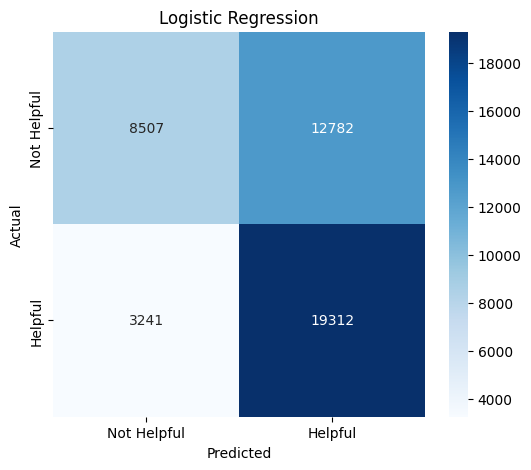

In [ ]:
# logistic regression
plot_confusion(y_test, y_pred, "Logistic Regression")

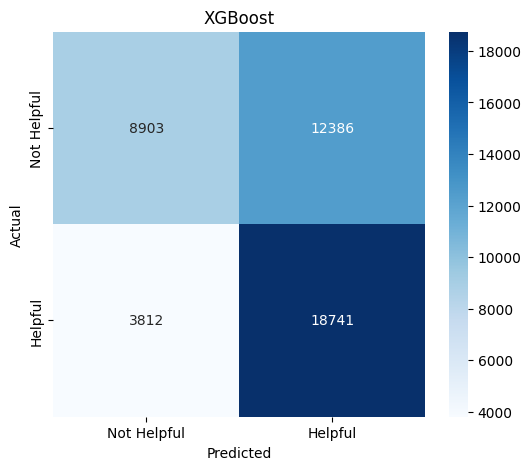

In [ ]:
# XG boost
plot_confusion(y_test, y_pred_xgb, "XGBoost")

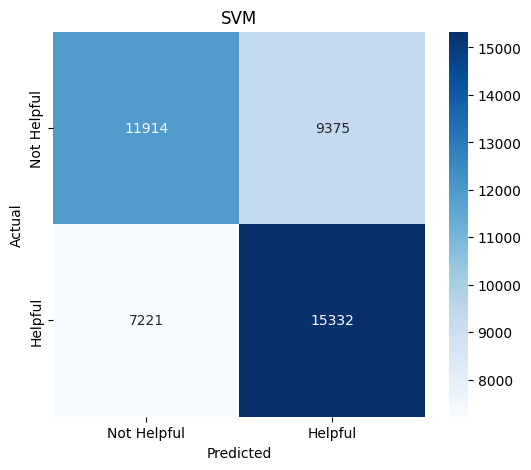

In [ ]:
# SVM
plot_confusion(y_test, y_pred_svm, "SVM")